Notebook pour entraîner un LoRA sur Stable Diffusion

Objectif : Apprendre au modèle à générer une voiture jaune spécifique.

# 1. Installation et Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm.auto import tqdm

from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler, EulerDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model

# 2. Configuration (Paramètres à ajuster)

In [2]:
# --- Modèle de base ---
model_id = "CompVis/stable-diffusion-v1-4"

# --- Données d'entraînement ---
instance_image_path = r"../example/car.jpg" # Chemin vers l'image
instance_prompt = "photo of sks car" # Prompt décrivant la voiture. "sks" est un placeholder unique
output_dir = "lora_car_output" # Dossier où sauvegarder le LoRA entraîné

# --- Paramètres d'entraînement ---
resolution = 512
train_batch_size = 1 # Garder à 1 si peu de VRAM
gradient_accumulation_steps = 1
learning_rate = 1e-4 # Taux d'apprentissage pour LoRA (souvent plus élevé que pour le full finetuning)
lr_scheduler = "cosine" # Type de scheduler pour le learning rate
lr_warmup_steps = 0
num_train_epochs = 100 # Nombre d'époques (peut nécessiter ajustement)
max_train_steps = 500 # Ou un nombre fixe d'étapes (ajuster epoch OU steps)
seed = 42
mixed_precision = "fp16" # Utiliser la précision mixte pour économiser mémoire/accélérer

# --- Paramètres LoRA ---
lora_rank = 4 # Rang de la matrice LoRA (plus petit = moins de paramètres, 4 ou 8 est courant)
lora_alpha = 4 # Alpha pour LoRA
lora_dropout = 0.1

# --- Création du dossier de sortie ---
os.makedirs(output_dir, exist_ok=True)

# 3. Chargement du Modèle Stable Diffusion

In [3]:
!huggingface-cli login

^C


In [ ]:
my_token="hf_XXXXXXXXXXXXXX" # Remplacez par votre token Hugging Face

In [6]:
# Charger les composants
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", token=my_token)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler") # Utiliser DDPMScheduler pour l'entraînement

# Geler les poids des modèles non entraînés (VAE et Text Encoder pour LoRA simple)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False) # Geler l'UNet de base avant d'ajouter LoRA

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

# 4. Ajout des Adaptateurs LoRA à l'UNet

In [7]:
# Configurer LoRA
lora_config = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_alpha,
    target_modules=["to_q", "to_v", "query", "value"], # Cible typiquement les couches d'attention
    lora_dropout=lora_dropout,
    bias="none",
)

# Ajouter les adaptateurs LoRA à l'UNet
unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters() # Affiche le nombre de paramètres entraînables (0.0464% du modèle total)

trainable params: 398,592 || all params: 859,919,556 || trainable%: 0.0464


# 5. Préparation des Données

In [8]:
# Transformation pour l'image
image_transforms = transforms.Compose([
    transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(resolution),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]), # Normalise entre -1 et 1
])

# Charger et transformer l'image
instance_image = Image.open(instance_image_path).convert("RGB")
instance_image_tensor = image_transforms(instance_image)

# Tokenizer le prompt
input_ids = tokenizer(
    instance_prompt,
    padding="max_length",
    truncation=True,
    max_length=tokenizer.model_max_length,
    return_tensors="pt"
).input_ids

# Création un "dataset" simple (juste notre image et prompt répétés)
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensor, input_ids):
        self.image_tensor = image_tensor
        self.input_ids = input_ids

    def __len__(self):
        return 1 # Ou plus si on veut utiliser plusieurs images/prompts

    def __getitem__(self, idx):
        return {"pixel_values": self.image_tensor, "input_ids": self.input_ids.squeeze()}

train_dataset = SimpleDataset(instance_image_tensor, input_ids)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size
)

# 6. Configuration de l'Entraînement

In [9]:
# Optimiseur (AdamW fonctionne bien pour LoRA)
# On optimise SEULEMENT les paramètres LoRA de l'UNet
optimizer = optim.AdamW(
    unet.parameters(), # PEFT s'assure qu'on optimise seulement les adaptateurs
    lr=learning_rate,
)

# Scheduler de Taux d'Apprentissage
# (Optionnel mais souvent utile)
if lr_scheduler == "cosine":
    from diffusers.optimization import get_cosine_schedule_with_warmup
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=lr_warmup_steps,
        num_training_steps=max_train_steps if max_train_steps else num_train_epochs * len(train_dataloader),
    )

# Accélérateur pour gérer le device et la précision mixte
accelerator = Accelerator(
    mixed_precision=mixed_precision,
    gradient_accumulation_steps=gradient_accumulation_steps,
)
print(f"Accelerate Device: {accelerator.device}")
import torch
print(f"PyTorch CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch Device Name: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch Current Device: {torch.cuda.current_device()}") # Donne l'index du GPU

# Préparer avec Accelerate
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# Déplacer les autres modèles sur le bon device ET AJUSTER LEUR PRECISION
# Déterminer le dtype cible basé sur la configuration de précision mixte
weight_dtype = torch.float16 if accelerator.mixed_precision == "fp16" else torch.float32

# Convertir VAE et Text Encoder (utilisés dans no_grad mais reçoivent/produisent des tenseurs pour UNet)
vae.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

# Activer les gradients seulement pour les paramètres LoRA (déjà fait par get_peft_model mais bonne pratique)
unet.train()

Accelerate Device: cuda
PyTorch CUDA Available: True
PyTorch Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
PyTorch Current Device: 0


PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_feat

In [10]:
print("-" * 20)
print("Vérification des devices AVANT la boucle:")
print(f"UNet device: {unet.device}") # Devrait être cuda après accelerator.prepare
print(f"VAE device: {vae.device}") # Devrait être cuda après le .to() corrigé
print(f"Text Encoder device: {text_encoder.device}") # Devrait être cuda après le .to() corrigé
# Vérifions un paramètre de l'optimiseur (il gère les poids LoRA de l'UNet)
if optimizer.param_groups and optimizer.param_groups[0]['params']:
     print(f"Optimizer (param 0) device: {optimizer.param_groups[0]['params'][0].device}")
print("-" * 20)

--------------------
Vérification des devices AVANT la boucle:
UNet device: cuda:0
VAE device: cuda:0
Text Encoder device: cuda:0
Optimizer (param 0) device: cuda:0
--------------------


# 7. Boucle d'Entraînement

In [11]:
print("***** Démarrage de l'entraînement LoRA *****")
print(f"  Nombre d'époques = {num_train_epochs}")
print(f"  Nombre d'étapes = {max_train_steps if max_train_steps else num_train_epochs * len(train_dataloader)}")
print(f"  Taille du batch = {train_batch_size}")
print(f"  Gradient Accumulation = {gradient_accumulation_steps}")

global_step = 0
progress_bar = tqdm(range(max_train_steps if max_train_steps else num_train_epochs * len(train_dataloader)), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Étapes")

for epoch in range(num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet): # Gère l'accumulation de gradient
            # --- Préparation du batch ---
            pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.float16 if mixed_precision == "fp16" else torch.float32)
            input_ids_batch = batch["input_ids"].to(accelerator.device) # Pas besoin de float16 pour les IDs

            # --- Encodage VAE ---
            # Convertir les images en latents
            with torch.no_grad(): # Pas besoin de gradients ici
                 # .sample() peut être bruité, .mean est plus stable pour l'encodage initial
                latents = vae.encode(pixel_values).latent_dist.sample()
                # latents = vae.encode(pixel_values).latent_dist.mean # Alternative
            latents = latents * vae.config.scaling_factor

            # --- Ajout de Bruit ---
            # Échantillonner du bruit aléatoire
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Échantillonner un timestep aléatoire pour chaque image du batch
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Ajouter le bruit aux latents (forward diffusion)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            # --- Encodage Texte ---
            # Obtenir les embeddings texte
            with torch.no_grad(): # Pas besoin de gradients ici
                encoder_hidden_states = text_encoder(input_ids_batch)[0].to(dtype=torch.float16 if mixed_precision == "fp16" else torch.float32)

            # --- Prédiction UNet ---
            # Prédire le bruit ajouté
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # --- Calcul de la Perte ---
            # Comparer le bruit prédit au bruit réellement ajouté
            loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

            # --- Rétropropagation ---
            accelerator.backward(loss)

            # --- Mise à jour des poids ---
            # Optionnel : Gradient Clipping (évite l'explosion des gradients)
            if accelerator.sync_gradients:
                 accelerator.clip_grad_norm_(unet.parameters(), 1.0)

            optimizer.step()
            if lr_scheduler:
                lr_scheduler.step()
            optimizer.zero_grad() # Important !

        # --- Logging & Sauvegarde ---
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"loss": loss.detach().item()}, step=global_step)

            # Sauvegarder les poids LoRA périodiquement
            if global_step % 100 == 0: # Sauvegarder toutes les 100 étapes
                save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                # Utiliser accelerator.unwrap_model pour sauvegarder le modèle de base
                unwrapped_unet = accelerator.unwrap_model(unet)
                unwrapped_unet.save_pretrained(save_path)
                print(f"Checkpoint sauvegardé à {save_path}")

        logs = {"loss": loss.detach().item(), "lr": optimizer.param_groups[0]['lr']}
        progress_bar.set_postfix(**logs)

        if max_train_steps and global_step >= max_train_steps:
            break
    if max_train_steps and global_step >= max_train_steps:
            break

# --- Sauvegarde Finale ---
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = accelerator.unwrap_model(unet)
    unet.save_pretrained(output_dir)
    print(f"Modèle LoRA final sauvegardé dans {output_dir}")
accelerator.end_training()
print("***** Entraînement Terminé *****")

***** Démarrage de l'entraînement LoRA *****
  Nombre d'époques = 100
  Nombre d'étapes = 500
  Taille du batch = 1
  Gradient Accumulation = 1


  0%|          | 0/500 [00:00<?, ?it/s]

Checkpoint sauvegardé à lora_car_output\checkpoint-100
Modèle LoRA final sauvegardé dans lora_car_output
***** Entraînement Terminé *****


# 8. Inférence avec le LoRA entraîné

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

d:\Users\ethan\Code Project\genai_project\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ethan\.cache\huggingface\hub\models--CompVis--stable-diffusion-v1-4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Poids LoRA chargés depuis lora_car_output


  0%|          | 0/30 [00:00<?, ?it/s]

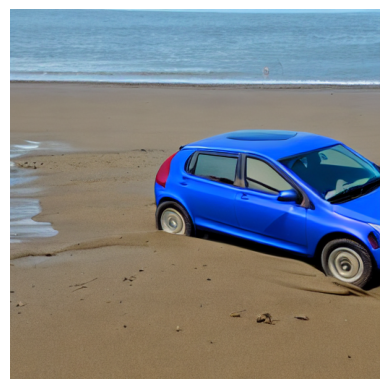

In [12]:
from diffusers import StableDiffusionPipeline
import torch

# Charger le pipeline de base
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to(accelerator.device) # Utiliser le device de l'accelerator

# Charger les poids LoRA entraînés
# Le dossier output_dir contient maintenant les poids LoRA (adapter_model.bin ou .safetensors)
# Si vous avez sauvegardé dans des checkpoints, utilisez le chemin du checkpoint désiré
lora_model_path = output_dir # Ou un chemin de checkpoint spécifique
pipe.load_lora_weights(lora_model_path)
print(f"Poids LoRA chargés depuis {lora_model_path}")

# Générer une image en utilisant le prompt qui inclut le token spécial
prompt = "photo of sks car driving on a beach" # Utiliser le même placeholder "sks"
# prompt = "photo of sks car" # Ou juste le concept
# prompt = "photo of a yellow car" # Pour comparer avec/sans LoRA

# Optionnel: Ajuster le poids du LoRA (cross_attention_kwargs)
# image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": 0.8}).images[0]
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

# Afficher ou sauvegarder l'image
plt.imshow(image)
plt.axis("off")
plt.show()
image.save(os.path.join(output_dir, "generated_with_lora.png"))